In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances
from statistics import mode
from joblib import Parallel, delayed
import multiprocessing
n_cores = multiprocessing.cpu_count()
from collections import Counter

# Build Dataset:

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [3]:
def build_dataset(X, y, shuffle=False, BATCH_SIZE=1024):
    BUFFER_SIZE = len(y)
    X = tf.cast(X[...,tf.newaxis]/255, tf.float32)
    y = tf.cast(y,tf.int64)
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        dataset = dataset.shuffle(BUFFER_SIZE)
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

In [4]:
train_ds = build_dataset(X_train, y_train)
valid_ds = build_dataset(X_valid, y_valid)
test_ds = build_dataset(X_test, y_test)

# LeNet-5 Model:

In [5]:
class LeNet5(tf.keras.Model):
    def __init__(self, dropout=0.25):
        super(LeNet5, self).__init__()
        self.dropout = dropout
        self.conv1 = tf.keras.layers.Conv2D(filters=6, 
                                            kernel_size=(3, 3), 
                                            activation='relu')
        self.pool1 = tf.keras.layers.AveragePooling2D()
        self.conv2 = tf.keras.layers.Conv2D(filters=16, 
                                            kernel_size=(3, 3), 
                                            activation='relu')
        self.pool2 = tf.keras.layers.AveragePooling2D()
        self.fc1 = tf.keras.layers.Dense(units=120, activation='relu')
        self.fc2 = tf.keras.layers.Dense(units=84, activation='relu')
        self.fc3 = tf.keras.layers.Dense(units=10)
        self.drop1 = tf.keras.layers.Dropout(self.dropout)
        self.drop2 = tf.keras.layers.Dropout(self.dropout)

    def call(self, inputs, training=False):
        outputs = self.conv1(inputs)
        outputs = self.pool1(outputs)
        outputs = self.conv2(outputs)
        outputs = self.pool2(outputs)
        outputs = tf.keras.layers.Flatten()(outputs)
        outputs = self.drop1(self.fc1(outputs), training=training)
        outputs = self.drop2(self.fc2(outputs), training=training)
        outputs = self.fc3(outputs)
        return outputs

In [6]:
model = LeNet5()
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
cp_cb = tf.keras.callbacks.ModelCheckpoint(filepath='model/model.ckpt',
                                           save_best_only=True,
                                           save_weights_only=True,
                                           verbose=1)

In [7]:
model.load_weights('model/model.ckpt')
model.trainable = False

# KNN (sklearn):

In [9]:
def get_report(y_true, y_pred):
    report = classification_report(y_true, y_pred, digits=4, output_dict=True)
    report = pd.DataFrame(report).transpose()
    return report

def get_cls_acc(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return pd.Series(cm.diagonal()/cm.sum(axis=1))

In [80]:
def lineplot(ax, scores, ylabel):
    for i, label in enumerate(models):
        ax.plot(scores[i], label=label)
    ax.set_ylabel(ylabel, fontsize=16)
    ax.legend(loc="upper right")

def get_sk_plot(X_train, X_test, y_train, y_test, fp):

    pre_scores = []
    rec_scores = []
    f1_scores = []
    acc_scores = []

    test_report = get_report(y_test, X_test.argmax(1))
    test_cls_acc = get_cls_acc(y_test, X_test.argmax(1))
    pre_scores.append(test_report['precision'][:10])
    rec_scores.append(test_report['recall'][:10])
    f1_scores.append(test_report['f1-score'][:10])
    acc_scores.append(test_cls_acc)

    for metric in ['euclidean', 'manhattan', 'cosine']:
        knn_model = KNeighborsClassifier(n_jobs=6, metric=metric)
        knn_model = knn_model.fit(X_train, y_train)
        train_pred = knn_model.predict(X_train)
        test_pred = knn_model.predict(X_test)
        train_report = get_report(y_train, train_pred)
        train_report.to_csv('reports/knn-{}-train.csv'.format(metric))
        test_report = get_report(y_test, test_pred)
        test_report.to_csv('reports/knn-{}-test.csv'.format(metric))
        train_cls_acc = get_cls_acc(y_train, train_pred)
        test_cls_acc = get_cls_acc(y_test, test_pred)

        pre_scores.append(test_report['precision'][:10])
        rec_scores.append(test_report['recall'][:10])
        f1_scores.append(test_report['f1-score'][:10])
        acc_scores.append(test_cls_acc)

    models = ['CNN', 'KNN-euclidean', 'KNN-manhattan', 'KNN-cosine']
    fig, ax = plt.subplots(2, 2, figsize=(12, 8))
    lineplot(ax[0, 0], pre_scores, 'Precision')
    lineplot(ax[0, 1], rec_scores, 'Recall')
    lineplot(ax[1, 0], acc_scores, 'Accuracy')
    lineplot(ax[1, 1], f1_scores, 'F1-score')
    ax[1, 0].set_xticks(np.arange(10))
    ax[0, 0].set_xlabel('Handwritten Digit', fontsize=18)
    ax[0, 1].set_xlabel('Handwritten Digit', fontsize=18)
    ax[1, 0].set_xlabel('Handwritten Digit', fontsize=18)
    ax[1, 1].set_xlabel('Handwritten Digit', fontsize=18)
    plt.tight_layout()

    plt.tight_layout()
    fig.savefig(fp, format='png', dpi=300)
    plt.show()

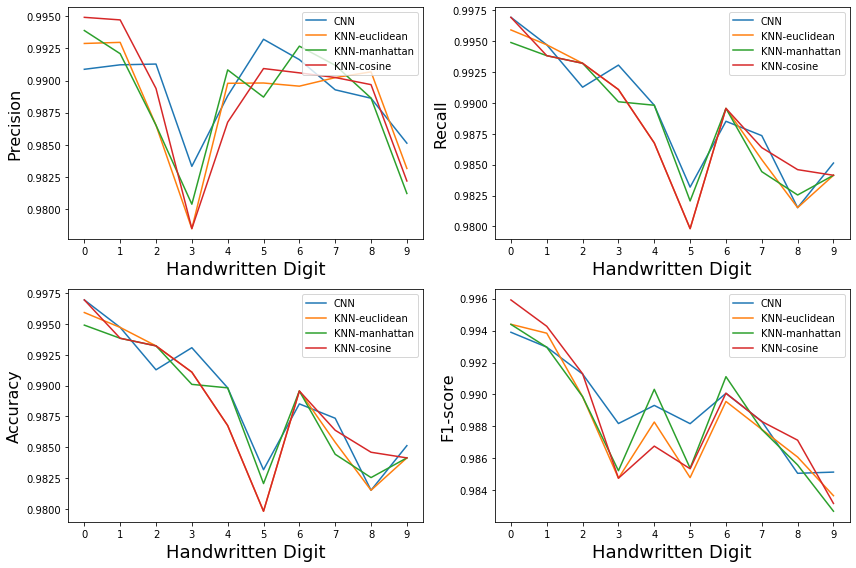

In [81]:
X_train = model.predict(train_ds)
X_test = model.predict(test_ds)
get_sk_plot(X_train, X_test, y_train, y_test, 'images/knn.png')

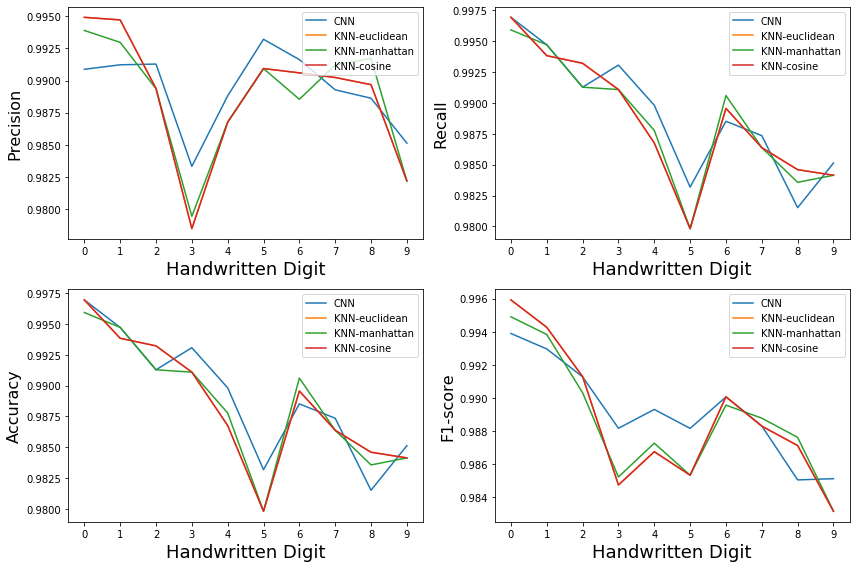

In [82]:
X_train = normalize(model.predict(train_ds))
X_test = normalize(model.predict(test_ds))
get_sk_plot(X_train, X_test, y_train, y_test, 'images/knn-norm.png')

# KNN (Euclidean):

In [27]:
def knn(data, query, labels, k=5, metric='euclidean'):
    distances = pairwise_distances(data, query[np.newaxis,:], metric=metric).flatten()
    distances = np.array(distances).flatten()
    indices = np.arange(len(data))
    sorted_index = np.argsort(distances)
    nn_indices = indices[sorted_index][:k]
    pred = Counter(labels[nn_indices]).most_common(1)[0][0]
    return pred

def knn_predict(X, k=5, metric='euclidean'):
    return Parallel(n_jobs=n_cores)(delayed(knn)(X_train, i, y_train, k=k, metric=metric) for i in X)

In [22]:
model.load_weights('model/model.ckpt')
model.trainable = False

In [83]:
def get_plot(X_train, X_test, y_train, y_test, fp):

    pre_scores = []
    rec_scores = []
    f1_scores = []
    acc_scores = []

    test_report = get_report(y_test, X_test.argmax(1))
    test_cls_acc = get_cls_acc(y_test, X_test.argmax(1))
    pre_scores.append(test_report['precision'][:10])
    rec_scores.append(test_report['recall'][:10])
    f1_scores.append(test_report['f1-score'][:10])
    acc_scores.append(test_cls_acc)

    for metric in ['euclidean', 'manhattan', 'cosine']:
        test_pred = knn_predict(X_test, metric=metric)
        test_report = get_report(y_test, test_pred)
        test_report.to_csv('reports/myknn-{}-test.csv'.format(metric))
        test_cls_acc = get_cls_acc(y_test, test_pred)

        pre_scores.append(test_report['precision'][:10])
        rec_scores.append(test_report['recall'][:10])
        f1_scores.append(test_report['f1-score'][:10])
        acc_scores.append(test_cls_acc)

    models = ['CNN', 'KNN-euclidean', 'KNN-manhattan', 'KNN-cosine']
    fig, ax = plt.subplots(2, 2, figsize=(12, 8))
    lineplot(ax[0, 0], pre_scores, 'Precision')
    lineplot(ax[0, 1], rec_scores, 'Recall')
    lineplot(ax[1, 0], acc_scores, 'Accuracy')
    lineplot(ax[1, 1], f1_scores, 'F1-score')
    ax[1, 0].set_xticks(np.arange(10))
    ax[0, 0].set_xlabel('Handwritten Digit', fontsize=18)
    ax[0, 1].set_xlabel('Handwritten Digit', fontsize=18)
    ax[1, 0].set_xlabel('Handwritten Digit', fontsize=18)
    ax[1, 1].set_xlabel('Handwritten Digit', fontsize=18)
    plt.tight_layout()

    plt.tight_layout()
    fig.savefig(fp, format='png', dpi=300)
    plt.show()

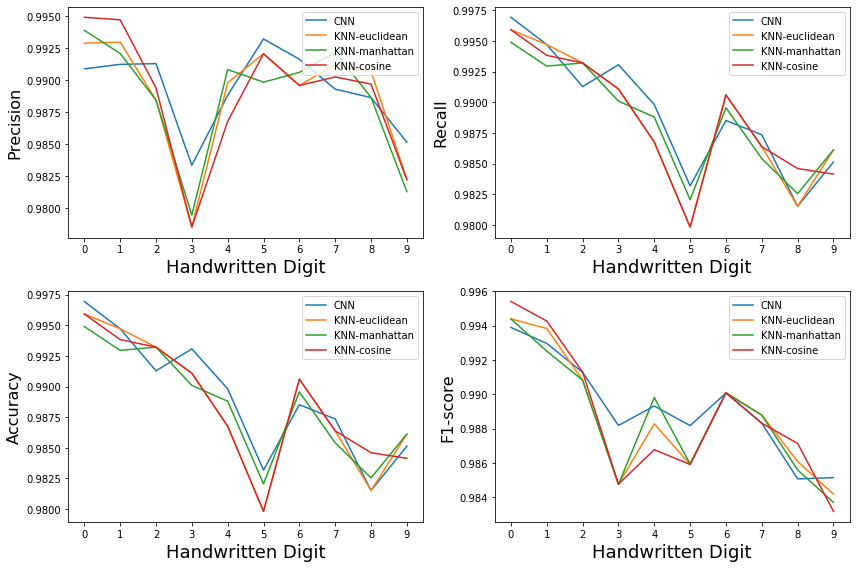

In [84]:
X_train = model.predict(train_ds)
X_test = model.predict(test_ds)
get_plot(X_train, X_test, y_train, y_test, 'images/myknn.png')

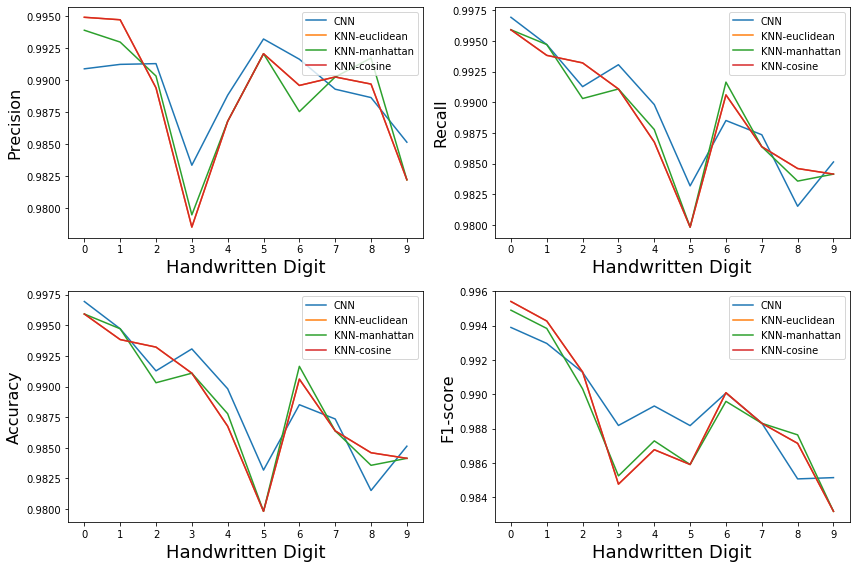

In [85]:
X_train = normalize(model.predict(train_ds))
X_test = normalize(model.predict(test_ds))
get_plot(X_train, X_test, y_train, y_test, 'images/myknn-norm.png')

# N-Neighbours:

In [86]:
X_train = normalize(model.predict(train_ds))
X_test = normalize(model.predict(test_ds))

In [87]:
test_preds = [knn_predict(X_test, k=k) for k in [1, 5, 25, 100]]

In [88]:
pre_scores = []
rec_scores = []
f1_scores = []
acc_scores = []

test_report = get_report(y_test, X_test.argmax(1))
test_cls_acc = get_cls_acc(y_test, X_test.argmax(1))
pre_scores.append(test_report['precision'][:10])
rec_scores.append(test_report['recall'][:10])
f1_scores.append(test_report['f1-score'][:10])
acc_scores.append(test_cls_acc)

for i, n in enumerate([1, 5, 25, 100]):
    test_pred = test_preds[i]
    test_report = get_report(y_test, test_pred)
    test_cls_acc = get_cls_acc(y_test, test_pred)

    pre_scores.append(test_report['precision'][:10])
    rec_scores.append(test_report['recall'][:10])
    f1_scores.append(test_report['f1-score'][:10])
    acc_scores.append(test_cls_acc)

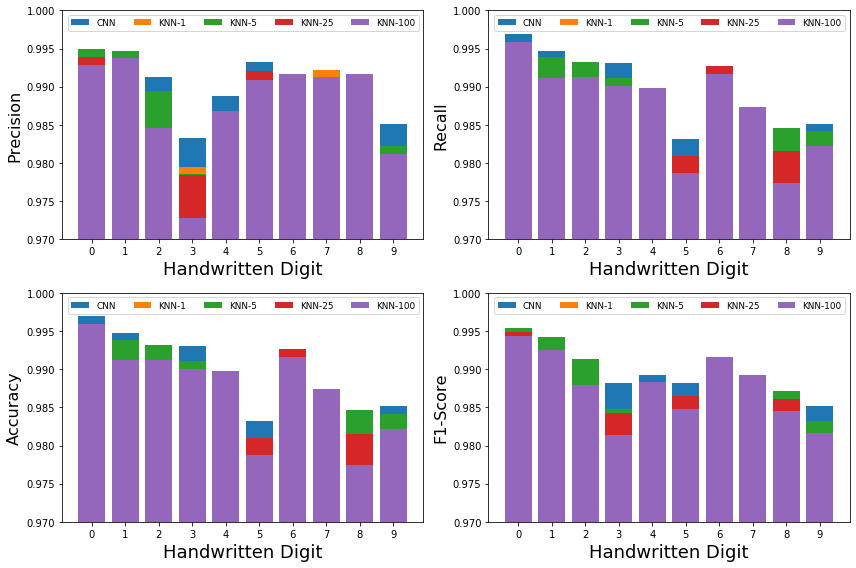

In [89]:
def barplot(ax, scores, ylabel):
    for i, label in enumerate(nns):
        ax.bar(x=np.arange(10), height=scores[i], label=label)
    ax.set_ylabel(ylabel, fontsize=16)
    ax.legend(ncol=5, prop={'size': 8.9})
    ax.set_ylim([.97,1.0])
    ax.set_xticks(np.arange(10))
    
nns = ['CNN', 'KNN-1', 'KNN-5', 'KNN-25', 'KNN-100']
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
barplot(ax[0,0], pre_scores, 'Precision')
barplot(ax[0,1], rec_scores, 'Recall')
barplot(ax[1,0], acc_scores, 'Accuracy')
barplot(ax[1,1], f1_scores, 'F1-Score')
ax[0, 0].set_xlabel('Handwritten Digit', fontsize=18)
ax[0, 1].set_xlabel('Handwritten Digit', fontsize=18)
ax[1, 0].set_xlabel('Handwritten Digit', fontsize=18)
ax[1, 1].set_xlabel('Handwritten Digit', fontsize=18)
plt.tight_layout()
fig.savefig('images/nn-knn.png'.format(metric), format='png', dpi=300)
plt.show()